<div align="center">

### **TALLER #2 SEÑALES Y SISTEMAS - 2025 2S**
#### **Estudiante:** Martín Ramírez Espinosa
##### Departamento de Ingeniería Eléctrica, Electrónica y Computación
##### Universidad Nacional de Colombia - Sede Manizales

</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter
import subprocess
from pathlib import Path
import soundfile as sf
import imageio_ffmpeg
from IPython.display import Audio

---

### **1. Transformada de Fourier**

#### **1.1. Consultar y realizar los ejercicios propuestos en el cuaderno 2_TransformadaFourier_SAudio.ipynb**

---

##### **a) Presente y describa el modelo que utiliza la FFT para el cálculo de los armónicos**

**Serie de Fourier continua**

Para una señal periódica $x(t)$ de periodo $T_0$, la serie de Fourier compleja representa a $x(t)$ como combinación lineal de armónicos:

<div align="center">

$$
x(t) = \sum_{k=-\infty}^{\infty} c_k e^{j k \omega_0 t}, \quad c_k = \frac{1}{T_0} \int_{t_0}^{t_0+T_0} x(t) e^{-j k \omega_0 t}\, dt,
$$

</div>

donde $\omega_0 = \frac{2\pi}{T_0}$ es la frecuencia angular fundamental. Al hacer tender $T_0$ a infinito, los índices discretos $k$ se densifican dando lugar a un espectro continuo.

**Transformada de Fourier (FT)**

El caso aperiódico se modela con la transformada de Fourier, límite continuo de la serie anterior:

<div align="center">

$$
X(\omega) = \int_{-\infty}^{\infty} x(t) e^{-j \omega t}\, dt, \qquad x(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} X(\omega) e^{j \omega t}\, d\omega.
$$

</div>

Estas expresiones enlazan la señal en el tiempo continuo con su densidad espectral continua sobre $\omega \in \mathbb{R}$.

**Transformada de Fourier de Tiempo Discreto (DTFT)**

Si $x(t)$ se muestrea idealmente con periodo $T_s$, se obtiene $x[n] = x(nT_s)$, es decir, un muestreo infinito. Su DTFT se expresa en términos de la frecuencia angular digital $\Omega$:

<div align="center">

$$
X(\Omega) = \sum_{n=-\infty}^{\infty} x[n] e^{-j \Omega n}, \qquad -\pi \le \Omega < \pi,
$$

</div>

y la relación inversa, que reconstruye $x[n]$ a partir de un periodo fundamental del espectro periódico, es

<div align="center">

$$
x[n] = \frac{1}{2\pi} \int_{-\pi}^{\pi} X(\Omega) e^{j \Omega n}\, d\Omega.
$$

</div>

El factor $\frac{1}{2\pi}$ y los límites $[-\pi, \pi)$ garantizan la ortonormalidad de las exponenciales discretas y reflejan que $X(\Omega)$ es $2\pi$-periódica en $\Omega$.

**Transformada Discreta de Fourier (DFT)**

Si la secuencia se trunca a un bloque finito de $N$ muestras, se emplea la DFT:

<div align="center">

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j k \frac{2\pi}{N} n}, \qquad k = 0, 1, \dots, N-1,
$$

</div>

con inversa

<div align="center">

$$
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j k \frac{2\pi}{N} n}, \qquad n = 0, 1, \dots, N-1.
$$

</div>

Las muestras $X[k]$ muestrean la DTFT cada $\frac{2\pi}{N}$ radianes, por lo que representan armónicos discretos de la señal.

**Modelo de la FFT para el cálculo de armónicos**

Calcular la DFT de forma directa exige $N$ sumas de $N$ productos complejos (orden $O(N^2)$). Los algoritmos FFT, como Cooley–Tukey, factorizan la DFT explotando simetrías de las exponenciales $W_N = e^{-j \frac{2\pi}{N}}$. Para $N = 2^m$, se separan las muestras en subsecuencias par $x_e[n] = x[2n]$ e impar $x_o[n] = x[2n+1]$, obteniendo

<div align="center">

$$
X[k] = X_e[k] + W_N^{k} X_o[k], \qquad X[k + \frac{N}{2}] = X_e[k] - W_N^{k} X_o[k],
$$

</div>

con $X_e[k]$ y $X_o[k]$ DFTs de tamaño $\frac{N}{2}$. Esta descomposición se aplica recursivamente hasta llegar a DFTs de 2 puntos ("butterflies").

En cada nivel de la recursión se realizan $N$ combinaciones lineales, y hay $\log_2 N$ niveles, por lo que el costo total es $O(N \log N)$. Gracias a esta reducción de complejidad, la FFT permite estimar simultáneamente todos los armónicos de señales largas o muestreadas en tiempo real sin incurrir en el costo cuadrático de la DFT directa.

---

##### **b) Realice una comparación del tiempo de cómputo requerido para el cálculo de la transformada discreta de Fourier utilizado la estimación por sumatoria vs la FFT. Pruebe distintos valores de longitud de la señal de entrada (4,8,16,32,64,128,256,512,1024,2048,4096). Presente una gráfica comparativa de los tiempos de ejecución en segundos vs la longitud de la señal de entrada.**

**Metodología de comparación**  
Se evalúa el costo computacional de calcular la DFT de un bloque de longitud $N$ de dos maneras:
1. **Sumatoria directa**: implementación $O(N^2)$ que aplica la definición de la DFT mediante la suma doble de exponenciales complejas.
2. **FFT (Cooley–Tukey)**: uso de `numpy.fft.fft`, que implementa un algoritmo de orden $O(N \log N)$.

Se generan secuencias reales con una semilla fija para hacer reproducibles los resultados. Para cada $N = 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096$ se mide el tiempo en segundos empleando `time.perf_counter()`. Finalmente, se presenta una tabla resumen y una gráfica de tiempo vs. longitud para comparar el crecimiento de la complejidad temporal.


In [3]:
# Longitudes a evaluar
signal_lengths = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# Implementación directa de la DFT mediante sumatoria (orden O(N^2))
def DFT(x):
    N = x.size
    n = np.arange(N)
    k = n[:, None]
    twiddle = np.exp(-2j * np.pi * k * n / N)
    return twiddle @ x

rng = np.random.default_rng()
times_dft = []
times_fft = []

for N in signal_lengths:
    signal = rng.standard_normal(N)  # señal real de referencia

    start = perf_counter()
    _ = DFT(signal)
    times_dft.append(perf_counter() - start)

    start = perf_counter()
    _ = np.fft.fft(signal)
    times_fft.append(perf_counter() - start)

results_df = pd.DataFrame({
    'Longitud N': signal_lengths,
    'Tiempo DFT [s]': times_dft,
    'Tiempo FFT [s]': times_fft,
})

results_df

,Longitud N,Tiempo DFT [s],Tiempo FFT [s]
0,4,0.004349,0.012821
1,8,0.000112,0.000047
2,16,0.000046,0.000083
3,32,0.000172,0.000028
4,64,0.002750,0.000084
5,128,0.025733,0.000054
6,256,0.015095,0.000089
7,512,0.059616,0.000090
8,1024,0.255855,0.000137
9,2048,0.990964,0.000144


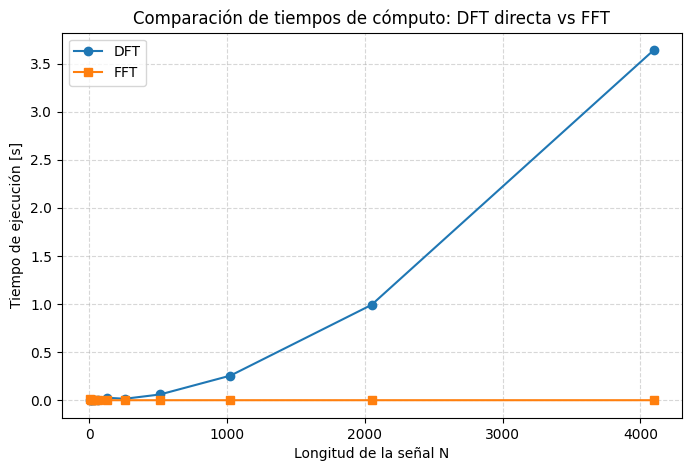

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['Longitud N'], results_df['Tiempo DFT [s]'], 'o-', label='DFT')
plt.plot(results_df['Longitud N'], results_df['Tiempo FFT [s]'], 's-', label='FFT')
plt.xlabel('Longitud de la señal N')
plt.ylabel('Tiempo de ejecución [s]')
plt.title('Comparación de tiempos de cómputo: DFT directa vs FFT')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()

---

##### **c) Consulte en qué consiste la frecuencia de -3dB y su relación con las frecuencias de corte en el filtrado espectral de señales.**

**Definición de la frecuencia de -3 dB**

En análisis en decibelios se representa la relación entre amplitudes como $20\log_{10}(A/A_0)$. El punto de $-3$ dB se alcanza cuando la magnitud $|H(j\omega)|$ cae a $A = A_0/\sqrt{2} \approx 0.707\,A_0$, equivalencia que también implica que la potencia $P = A^2$ se reduce a la mitad. Ese umbral se adopta como referencia para marcar la transición entre banda de paso y banda de atenuación de un filtro lineal.


**Vínculo con las frecuencias de corte**
 
La frecuencia de corte $\omega_c$ de un filtro LTI se define justamente por la condición $|H(j\omega_c)| = A_0/\sqrt{2}$, o de forma logarítmica $20\log_{10}(|H(j\omega_c)|/A_0) = -3\,\mathrm{dB}$. Para un filtro pasa bajas, $\omega_c$ fija el límite superior de la banda de paso; en un pasa altas fija el límite inferior. En topologías pasa banda y rechaza banda aparecen dos puntos de $-3$ dB, $\omega_{c1}$ y $\omega_{c2}$, cuyos valores determinan el ancho de banda efectivo $B_w = \omega_{c2} - \omega_{c1}$.

**Relevancia en el filtrado espectral**

Durante el diseño y la caracterización espectral de un filtro, localizar las frecuencias de $-3$ dB sobre $|H(j\omega)|$ permite cuantificar qué componentes de la señal permanecen dentro de la banda útil y evaluar la selectividad del sistema. Estos puntos sirven para comparar respuestas prácticas con especificaciones teóricas, asegurar que la atenuación fuera de banda sea suficiente y verificar que la banda de paso preserve la energía relevante de la señal.

##### **d) Implemente un filtro pasa bajas, un pasa altas, un pasa bandas, y un rechaza bandas utilizando la FFT y la iFFT sobre 5 segundos de su canción favorita de YouTube.**

In [ ]:
ffmpeg_path = imageio_ffmpeg.get_ffmpeg_exe()

# Descargar audio de YouTube usando yt-dlp
link = "https://www.youtube.com/watch?v=AKAiUtWZ4xY&list=RDAKAiUtWZ4xY&start_radio=1"
yt_dlp_cmd = [
    'yt-dlp',
    '--no-playlist',
    '--extract-audio',
    '--audio-format', 'wav',
    '--ffmpeg-location', ffmpeg_path,
    '-o', 'audio.%(ext)s',
    link,
]
subprocess.run(yt_dlp_cmd, check=True)

wav_candidates = sorted(Path('.').glob('audio*.wav'), key=lambda p: p.stat().st_mtime, reverse=True)
if not wav_candidates:
    raise FileNotFoundError('.wav file not found after download.')
wav_path = wav_candidates[0]

In [6]:
audio, F_s = sf.read(wav_path)
audio.shape

(2764800, 2)

In [10]:
t_0 = 30 # [s]
t_f = 35 # [s]
audio_segment = audio[int(t_0*F_s):int(t_f*F_s), :]
Audio(audio_segment.T, rate=F_s)

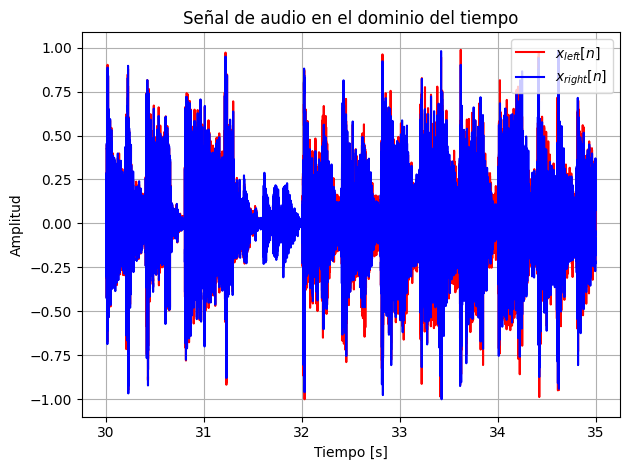

In [ ]:
x_n = audio_segment.copy()        # x[n] Segmento de audio estéreo
t_n = np.arange(t_0, t_f, 1/F_s)  # t_n [s] Vector de tiempos muestreados

plt.figure()
plt.plot(t_n, x_n[:, 0], label='$x_{left}[n]$', color='red')    # canal izquierdo
plt.plot(t_n, x_n[:, 1], label='$x_{right}[n]$', color='blue')  # canal derecho
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Señal de audio en el dominio del tiempo')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

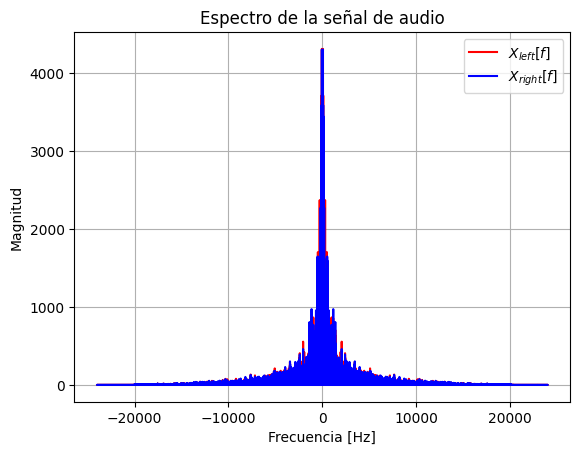

In [62]:
X_k = np.fft.fft(x_n, axis=0)  # Transformada de Fourier de la señal de audio
f = np.fft.fftfreq(x_n.shape[0], d=1/F_s)  # Vector de frecuencias
plt.figure()
plt.plot(f, np.abs(X_k[:, 0]), label='$X_{left}[f]$', color='red')
plt.plot(f, np.abs(X_k[:, 1]), label='$X_{right}[f]$', color='blue')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.title('Espectro de la señal de audio')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [57]:
# Filtro pasa bajos
f_c = 1000                             # Frecuencia de corte [Hz]
H_k = np.where(np.abs(f) <= f_c, 1, 0)  # Respuesta en frecuencia del filtro

# Aplicar el filtro
lpf_k = X_k * H_k[:, None]
lpf_n = np.fft.ifft(lpf_k, axis=0).real  # Señal filtrada en el dominio del tiempo
Audio(lpf_n.T, rate=F_s)

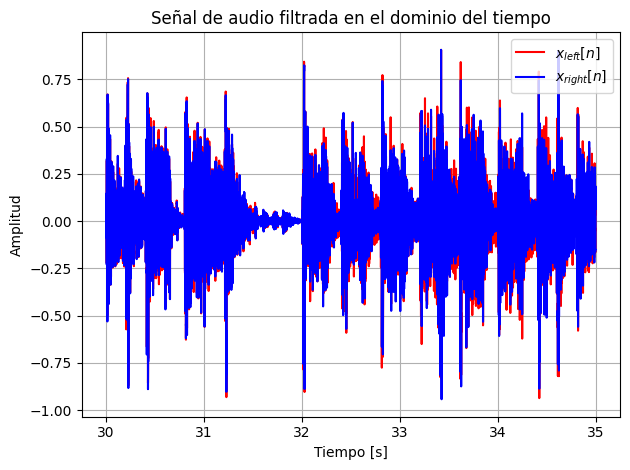

In [60]:
plt.figure()
plt.plot(t_n, lpf_n[:, 0], label='$x_{left}[n]$', color='red')    # canal izquierdo
plt.plot(t_n, lpf_n[:, 1], label='$x_{right}[n]$', color='blue')  # canal derecho
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Señal de audio filtrada en el dominio del tiempo')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

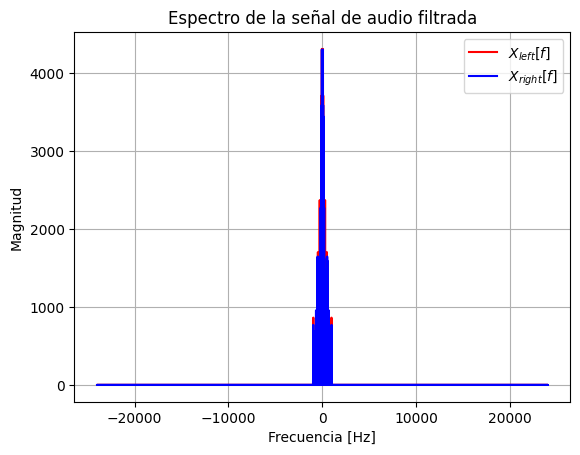

In [63]:
plt.figure()
plt.plot(f, np.abs(lpf_k[:, 0]), label='$X_{left}[f]$', color='red')
plt.plot(f, np.abs(lpf_k[:, 1]), label='$X_{right}[f]$', color='blue')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud')
plt.title('Espectro de la señal de audio filtrada')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [74]:
# Filtro pasa altos
f_c = 4000                             # Frecuencia de corte [Hz]
H_k = np.where(np.abs(f) >= f_c, 1, 0)  # Respuesta en frecuencia del filtro

# Aplicar el filtro
hpf_k = X_k * H_k[:, None]
hpf_n = np.fft.ifft(hpf_k, axis=0).real  # Señal filtrada en el dominio del tiempo
Audio(hpf_n.T, rate=F_s)